# Clustering Steel Grades Based on Microstructure and Yield Strength

In [24]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Load dataset
df = pd.read_excel("steel_microstructure_dataset_2000.xlsx")
df.head()


,Grain_Size_μm,Ferrite_%,Pearlite_%,Bainite_%,Martensite_%,Inclusion_Content_ppm,Dislocation_Density_1e14/m2,Carbide_Size_nm,Yield_Strength_MPa
0,17.48,51.26,35.54,6.60,6.60,30.46,8.73,28.62,470.40
1,18.84,0.37,63.13,32.19,4.30,52.73,2.24,32.42,257.06
2,6.38,49.85,7.91,18.20,24.03,102.09,7.96,24.38,435.85
3,7.88,43.41,2.30,45.24,9.04,31.71,9.51,23.99,464.26
4,11.99,4.01,21.04,1.08,73.88,66.58,6.79,48.52,454.66


In [25]:

features = df.drop(columns=["Yield_Strength_MPa"])
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

features_scaled_df = pd.DataFrame(features_scaled, columns=features.columns)
features_scaled_df.head()


,Grain_Size_μm,Ferrite_%,Pearlite_%,Bainite_%,Martensite_%,Inclusion_Content_ppm,Dislocation_Density_1e14/m2,Carbide_Size_nm
0,0.468870,1.411989,0.518444,-0.919419,-0.978578,-1.517228,1.288295,-0.124011
1,0.741843,-1.293515,1.934094,0.416314,-1.096732,-1.088881,-1.089674,0.252977
2,-1.759074,1.337028,-0.899258,-0.313929,-0.083176,-0.139479,1.006163,-0.544651
3,-1.458001,0.994654,-1.187109,1.097491,-0.853232,-1.493185,1.574091,-0.583341
4,-0.633059,-1.099999,-0.225555,-1.207549,2.477685,-0.822487,0.577469,1.850216


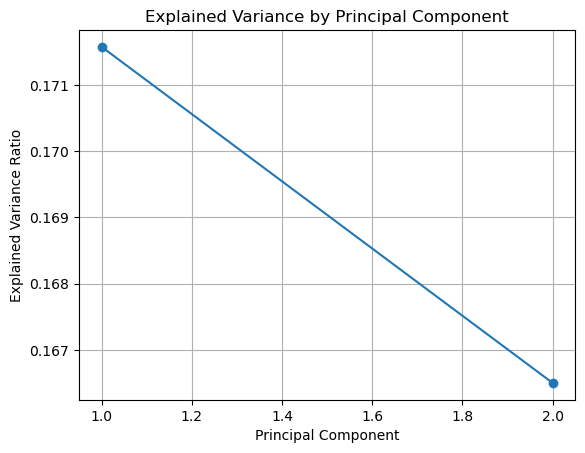

In [28]:

pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_scaled)

pca_df = pd.DataFrame(features_pca, columns=["PC1", "PC2"])

plt.plot(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_, marker='o')
plt.title("Explained Variance by Principal Component")
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.grid(True)
plt.show()


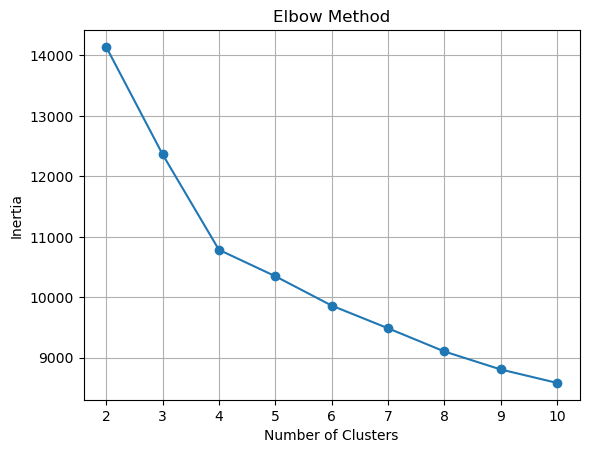

In [30]:

inertia = []
k_values = range(2, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(k_values, inertia, marker='o')
plt.title("Elbow Method")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()


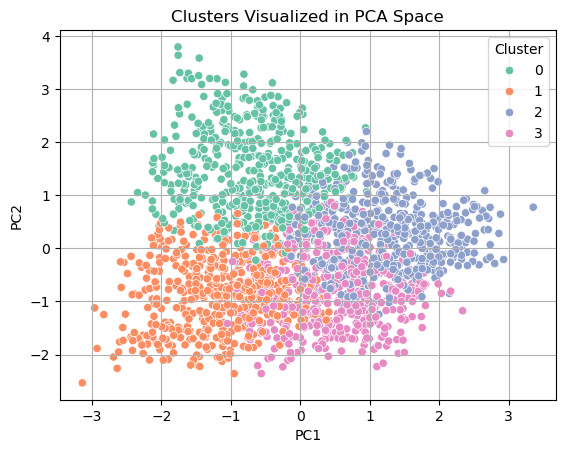

In [31]:

k_opt = 4  # Choose based on elbow curve
kmeans = KMeans(n_clusters=k_opt, random_state=42)
clusters = kmeans.fit_predict(features_scaled)

pca_df["Cluster"] = clusters

sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="Cluster", palette="Set2")
plt.title("Clusters Visualized in PCA Space")
plt.grid(True)
plt.show()


## Evaluate Clustering Performance

In [34]:

from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Silhouette Score (higher is better)
sil_score = silhouette_score(features_scaled, clusters)
print(f"Silhouette Score: {sil_score:.4f}")

# Calinski-Harabasz Index (higher is better)
ch_score = calinski_harabasz_score(features_scaled, clusters)
print(f"Calinski-Harabasz Score: {ch_score:.2f}")

# Davies-Bouldin Index (lower is better)
db_score = davies_bouldin_score(features_scaled, clusters)
print(f"Davies-Bouldin Score: {db_score:.4f}")


Silhouette Score: 0.1624
Calinski-Harabasz Score: 321.68
Davies-Bouldin Score: 1.7237


In [35]:

# Analyze Yield Strength across clusters
clustered_df = df.copy()
clustered_df['Cluster'] = clusters

# Mean yield strength for each cluster
mean_strength_per_cluster = clustered_df.groupby("Cluster")["Yield_Strength_MPa"].mean()
print("Mean Yield Strength per Cluster:")
print(mean_strength_per_cluster)


Mean Yield Strength per Cluster:
Cluster
0    368.893140
1    399.697100
2    368.638451
3    364.241500
Name: Yield_Strength_MPa, dtype: float64


## Predict Cluster for a New Sample

The predicted cluster for the new steel sample is: 3


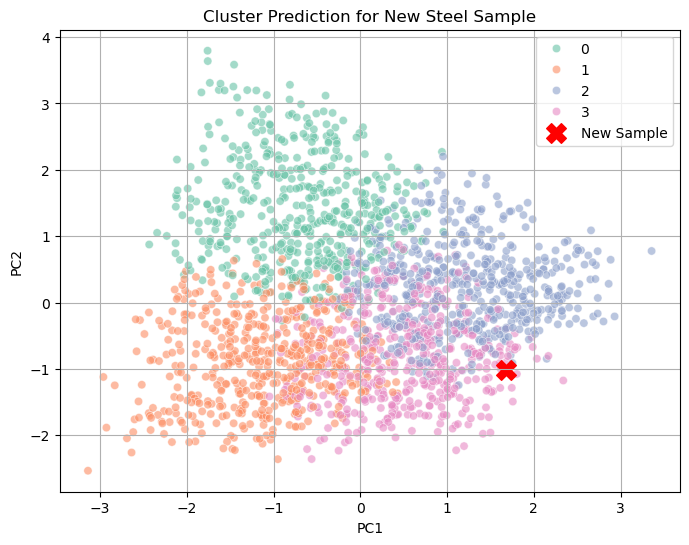

In [73]:

#  New sample (update these values as needed)
new_sample = pd.DataFrame([{
    "Ferrite_%": 60,
    "Pearlite_%": 30,
    "Bainite_%": 5,
    "Martensite_%": 5,
    "Grain_Size_μm": 15,
    "Inclusion_Content_ppm": 1.5,
    "Carbide_Size_nm" : 40.2,
    "Dislocation_Density_1e14/m2" : 7.9,
    
    "C_%": 0.2,
    "Mn_%": 0.8,
    "Si_%": 0.3,
    "P_%": 0.015,
    "S_%": 0.01
}])

#  Ensure columns are in the same order as training data
new_sample = new_sample[features.columns]

#  Apply same scaler
new_sample_scaled = scaler.transform(new_sample)

# Predict cluster
predicted_cluster = kmeans.predict(new_sample_scaled)[0]
print("The predicted cluster for the new steel sample is:", predicted_cluster)

#  For visualization only (optional)
new_sample_pca = pca.transform(new_sample_scaled)
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="Cluster", palette="Set2", alpha=0.6)
plt.scatter(new_sample_pca[0, 0], new_sample_pca[0, 1], color="red", marker="X", s=200, label="New Sample")
plt.title("Cluster Prediction for New Steel Sample")
plt.legend()
plt.grid(True)
plt.show()

